# Lidar-Topobathy Data Fusion

In [1]:
from __future__ import annotations
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import numpy.typing as npt
import shapely
import rasterio as rio
import pandas as pd

import py3dep
from pygeohydro import EHydro
import pygeoutils as pgu

import curviriver as cr

In [2]:
FloatArray = npt.NDArray[np.float64]

## Topobathy Point Clouds from eHydro

In [3]:
ehydro = EHydro()
ehydro.survey_grid.explore()

In [4]:
ehydro = EHydro("outlines")
geom = ehydro.survey_grid.loc[ehydro.survey_grid["OBJECTID"] == 210, "geometry"].iloc[0]
outline = ehydro.bygeom(geom, ehydro.survey_grid.crs)
ehydro = EHydro("points")
cloud = ehydro.bygeom(geom, ehydro.survey_grid.crs)

## Resampling Point Clouds on a Curvilinear Grid

![vd](vd.png)

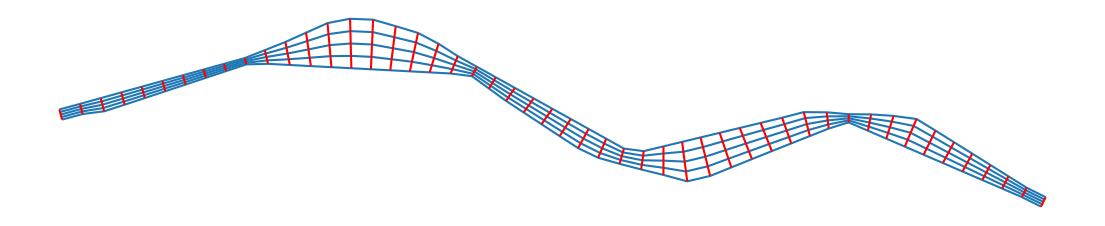

In [5]:
poly = outline.convex_hull.unary_union
spacing_streamwise = 2000
xs_npts = 5
stream = cr.poly_segmentize(poly, outline.crs, spacing_streamwise, xs_npts)
transect = gpd.GeoSeries(
    [
        shapely.LineString(stream.get_coordinates(index_parts=True).swaplevel().loc[i, :])
        for i in range(xs_npts)
    ],
    crs=stream.crs,
)
ax = transect.plot(figsize=(14, 14))
stream.plot(ax=ax, color="r")
ax.set_axis_off()

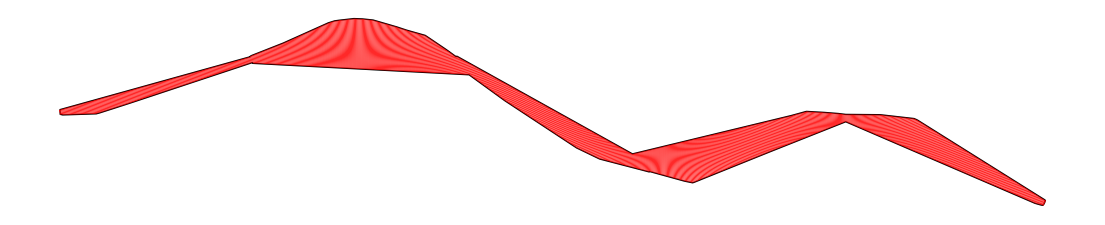

In [6]:
poly = outline.convex_hull.unary_union
spacing_streamwise = 100
xs_npts = 50
stream = cr.poly_segmentize(poly, outline.crs, spacing_streamwise, xs_npts)
xs_cloud = cr.idw_line_interpolation(cloud, stream, "Z_use", grid_points=True, search_radius_coeff=0.5)
ax = gpd.GeoSeries([poly]).plot(facecolor="none", edgecolor=["k", "r"], figsize=(14, 14))
stream.plot(ax=ax, color="r", linewidth=0.6)
ax.set_axis_off()

In [7]:
xs_cloud = cr.idw_line_interpolation(cloud, stream, "Z_use", grid_points=True, search_radius_coeff=3)

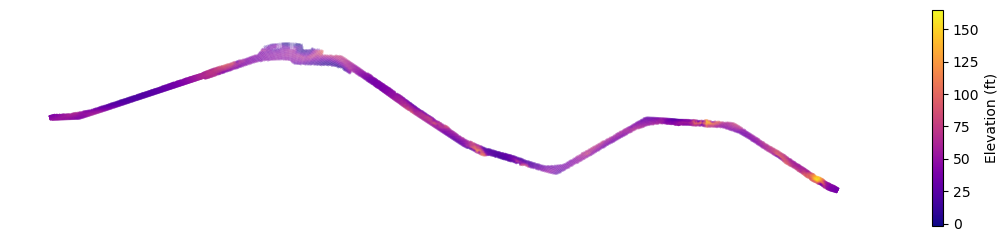

In [8]:
vmin, vmax = xs_cloud.Z_use.min(), xs_cloud.Z_use.max()
ax = xs_cloud.plot(
    column="Z_use",
    cmap="plasma",
    vmin=vmin,
    vmax=vmax,
    markersize=0.01,
    legend=True,
    legend_kwds={"label": "Elevation (ft)", "shrink": 0.2},
    figsize=(14, 14),
)
ax.set_axis_off()

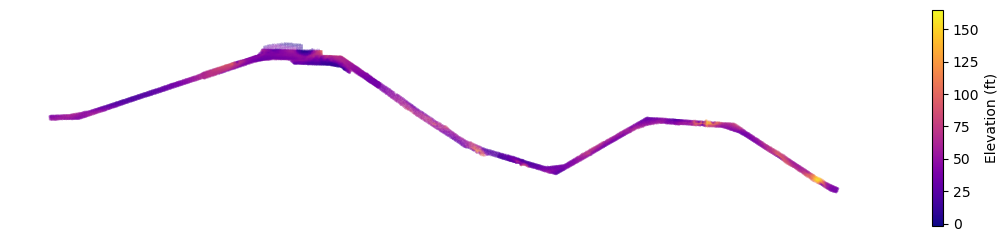

In [9]:
ax = cloud.plot(
    column="Z_use",
    cmap="plasma",
    vmin=vmin,
    vmax=vmax,
    markersize=0.01,
    legend=True,
    legend_kwds={"label": "Elevation (ft)", "shrink": 0.2},
    figsize=(14, 14),
)
ax.set_axis_off()

## Data Fusion

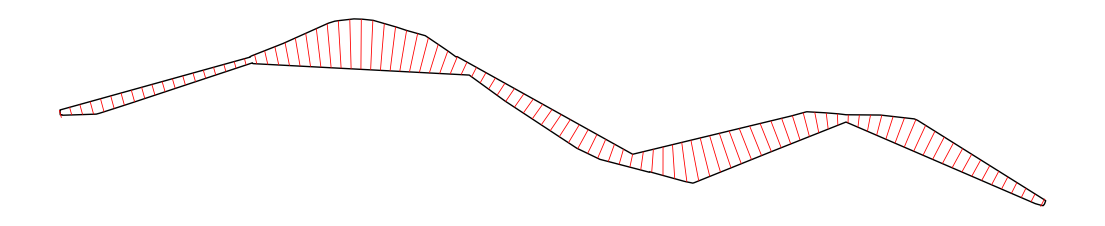

In [10]:
poly = outline.convex_hull.unary_union
spacing_streamwise = 1000
xs_npts = 500
stream = cr.poly_segmentize(poly, outline.crs, spacing_streamwise, xs_npts)
xs_cloud = cr.idw_line_interpolation(cloud, stream, "Z_use", grid_points=True, search_radius_coeff=3)
not_nan = xs_cloud.Z_use.notna()
pc = np.c_[xs_cloud.geometry.x[not_nan], xs_cloud.geometry.y[not_nan], xs_cloud.Z_use[not_nan]]
ax = gpd.GeoSeries([poly]).plot(facecolor="none", edgecolor=["k", "r"], figsize=(14, 14))
stream.plot(ax=ax, color="r", linewidth=0.6)
ax.set_axis_off()

In [11]:
cl = cr.poly_centerline(poly)
cr.pc_average_distance(pc, cl, cross_section=True)

509.01013934897657

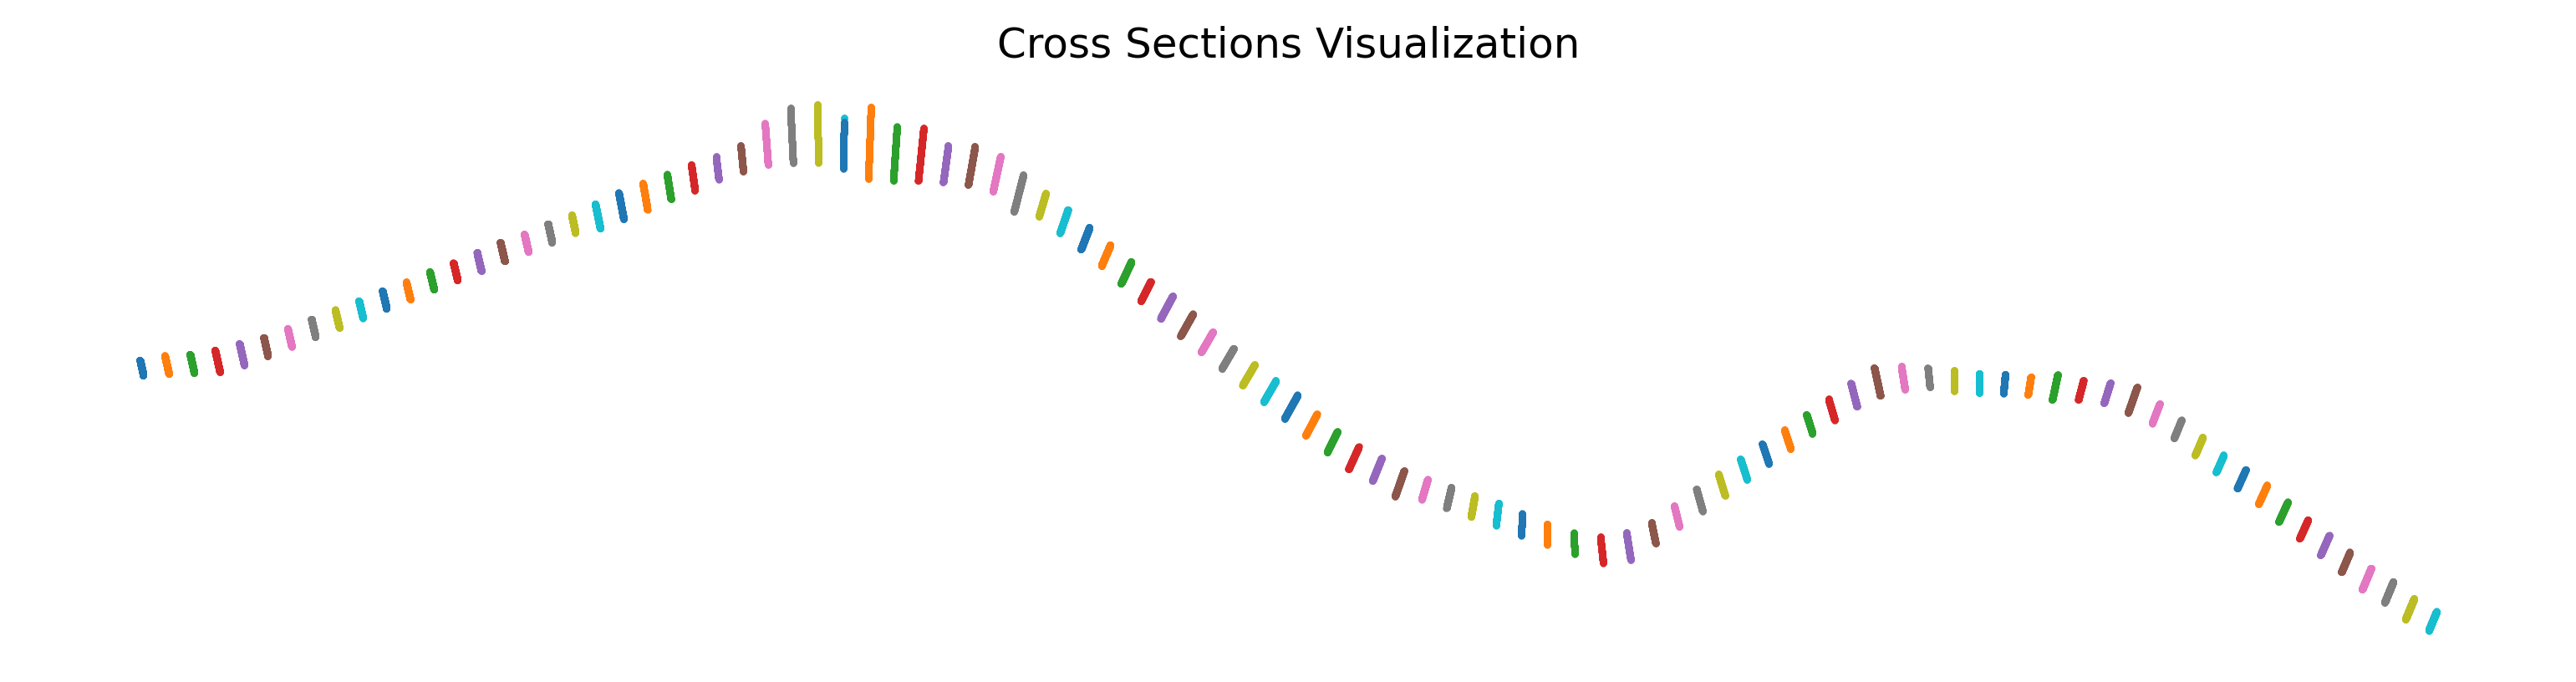

In [12]:
import matplotlib.pyplot as plt
cl = cr.poly_centerline(poly)
def visualize_cross_sections(point_cloud: FloatArray)->None:
    cross_sections = cr.extract_xsections(point_cloud, cl)
    plt.figure(figsize=(13, 3), dpi=300)
    for i, section in enumerate(cross_sections):
        plt.scatter(section[:, 0], section[:, 1], label=f'Cross Section {i + 1}', s=1)
    plt.title('Cross Sections Visualization')
    plt.axis("off")
visualize_cross_sections(pc)

In [13]:
poly = outline.convex_hull.unary_union
py3dep.check_3dep_availability(poly.bounds, outline.crs)

{'1m': True,
 '3m': True,
 '5m': False,
 '10m': True,
 '30m': True,
 '60m': False,
 'topobathy': False}

In [20]:
import hashlib
from tqdm.auto import tqdm

def _rio_sample(src: rio.DatasetReader, xy: zip[tuple[float, float]])->npt.NDArray[np.float64]:
    """Sample raster values at given coordinates."""
    return np.array(list(src.sample(xy))).ravel()


def topobathy_data_fusion(xs_centerline: shapely.LineString, xs_profile: gpd.GeoSeries, buffer_multiplier: int, dem_res: int)->gpd.GeoSeries:
    """Fusion of topographic (DEM) and bathymetric data.

    Parameters
    ----------
    xs_centerline : shapely.LineString
        Centerline of the cross-section profiles. It must be
        in the same CRS as ``xs_profile``.
    xs_profile : geopandas.GeoSeries
        Cross-section profiles. All geometries should be
        LineStrings with Z values. A projected CRS is highly
        recommended.
    buffer_multiplier : int
        Multiplier for the buffering ``xs_centerline``. The buffer is
        the maximum length of LineStrings in ``xs_profile`` multiplied
        by ``buffer_multiplier``.
    dem_res : int
        DEM resolution in meters.

    Returns
    -------
    geopandas.GeoSeries
        Extended cross-section profiles with fused elevation values.
    """
    if not isinstance(xs_centerline, shapely.LineString):
        raise TypeError("xs_centerline must be a shapely LineString.")
    if not isinstance(xs_profile, gpd.GeoSeries):
        raise TypeError("xs_profile must be a GeoSeries.")
    if not xs_profile.has_z.any():
        raise ValueError("xs_profile must have a Z-coordinates.")

    buff_len = np.ceil(xs_profile.length.max() * buffer_multiplier)
    center_buff = xs_centerline.buffer(buff_len, cap_style="flat")
    center_buff = pgu.geometry_reproject(center_buff, xs_profile.crs, 5070)
    dem_bound = np.ceil(center_buff.buffer(dem_res * 5).bounds)
    dem_bound = pgu.geometry_reproject(tuple(dem_bound), 5070, 4326)

    xs_profile = xs_profile.copy()
    xs_crs = xs_profile.crs
    for i, pts in xs_profile.get_coordinates(include_z=True).groupby(level=0):
        z = cr.interpolate_na(pts.x.to_numpy(), pts.y.to_numpy(), pts.z.to_numpy(), 0.0)
        xs_profile[i] = shapely.LineString(zip(pts.x, pts.y, z))

    key = hashlib.sha256()
    key.update(",".join(str(round(b, 6)) for b in dem_bound).encode())
    dem_path = Path("cache", f"{key.hexdigest()}.vrt")
    if not dem_path.exists():
        _ = py3dep.get_dem_vrt(dem_bound, dem_res, dem_path)
        print(f"DEM saved to {dem_path}.")
    else:
        print(f"DEM loaded from {dem_path}.")

    with rio.open(dem_path) as src:
        center_buff = pgu.geometry_reproject(center_buff, 5070, src.crs)
        for i, pts in tqdm(xs_profile.to_crs(src.crs).get_coordinates(include_z=True).groupby(level=0)):
            line = shapely.LineString(zip(pts.x, pts.y))
            if not line.intersects(center_buff) or line.intersects(center_buff.exterior):
                xs_profile.drop(i, inplace=True)
                continue

            xs_elev = pd.Series(_rio_sample(src, zip(*line.coords.xy)), index=pts.index)
            elev_m = xs_elev.mean() - pts.z * 0.3048
            line_ext = cr.line_extension(line, center_buff)
            xs_x, xs_y = line_ext.coords.xy
            line_ext = line_ext.difference(line)
            elev_l = _rio_sample(src, zip(*line_ext.geoms[0].coords.xy))
            elev_r = _rio_sample(src, zip(*line_ext.geoms[1].coords.xy))
            elev = np.concatenate([elev_l, elev_m, elev_r])
            xs_profile[i] = shapely.LineString(zip(xs_x, xs_y, elev))
        return xs_profile.set_crs(src.crs, allow_override=True).to_crs(xs_crs)

In [15]:
poly = outline.convex_hull.unary_union
spacing_streamwise = 100
xs_npts = 50
stream = cr.poly_segmentize(poly, outline.crs, spacing_streamwise, xs_npts)
xs_profile = cr.idw_line_interpolation(cloud, stream, "Z_use")
xs_centerline = cr.poly_centerline(poly)
xs_profile = topobathy_data_fusion(xs_centerline, xs_profile, 2, 1)

DEM loaded from cache/aa9a99cacc92278502c4d13fc4249ea07d9fd0c90483b257c3c9c56ec1e6e613.vrt.


  0%|          | 0/983 [00:00<?, ?it/s]

In [16]:
# xs = cr.idw_line_interpolation(cloud, stream, "Z_use")
# pts = xs.get_coordinates(include_z=True).groupby(level=0)
# for i, pts in xs.get_coordinates(include_z=True).groupby(level=0):
#     z = cr.interpolate_na(pts.x.to_numpy(), pts.y.to_numpy(), pts.z.to_numpy(), 0.0)
#     xs[i] = shapely.LineString(zip(pts.x, pts.y, z))

# x, y, z = shapely.get_coordinates(xs, include_z=True).T
# grid =  gpd.GeoDataFrame(
#     {"z": z}, geometry=gpd.points_from_xy(x, y, crs=xs.crs)
# )
# vmin, vmax = grid.z.min(), grid.z.max()
# ax = grid.plot(
#     column="z",
#     cmap="plasma",
#     vmin=vmin,
#     vmax=vmax,
#     markersize=0.01,
#     legend=True,
#     legend_kwds={"label": "Elevation (ft)", "shrink": 0.2},
#     figsize=(14, 14),
# )
# ax.set_axis_off()

In [24]:
xs_series = {i: pd.Series(pts.z.to_numpy(), index=np.insert(np.hypot(np.diff(pts.x), np.diff(pts.y)).cumsum(), 0, 0)) for i, pts in xs_profile.to_crs(5070).get_coordinates(include_z=True).groupby(level=0)}
xs_con = pd.concat(xs_series).describe()
ymin, ymax = xs_con.loc["min"], xs_con.loc["max"]
xmin = min(df.index[0] for df in xs_series.values())
xmax = max(df.index[-1] for df in xs_series.values())
for i, df in xs_series.items():
    fig, ax = plt.subplots(figsize=(6, 2))
    df.plot(ax=ax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel("Distance from left bank (m)")
    ax.set_ylabel("Elevation (m)")
    fig.savefig(f"plots/{i}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

In [25]:
!ffmpeg -framerate 16 -i plots/%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx265 -preset medium -crf 28 -pix_fmt yuv420p -hide_banner -loglevel quiet -y columbia_topobathy_fusion.mp4 > /dev/null 2>&1

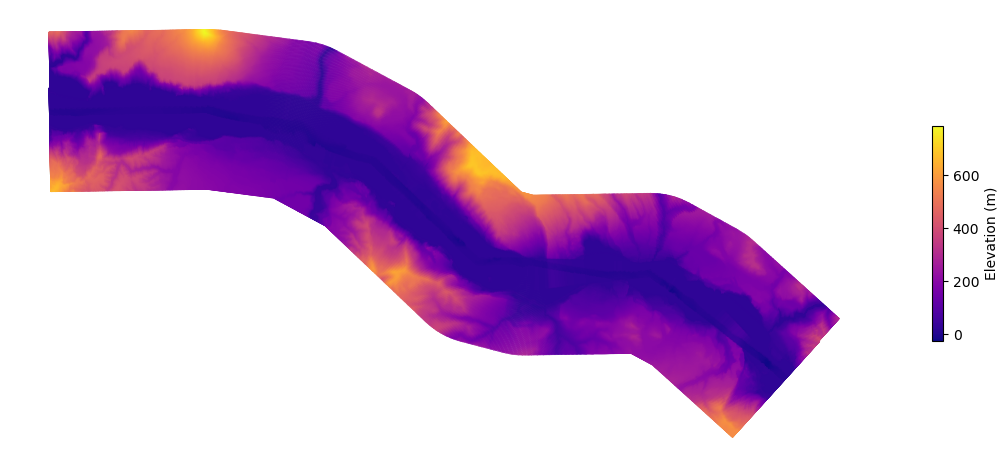

In [26]:
xs_x, xs_y, z = shapely.get_coordinates(xs_profile, include_z=True).T
grid = gpd.GeoDataFrame(
    {"Z_use": z}, geometry=gpd.points_from_xy(xs_x, xs_y, crs=xs_profile.crs)
)
vmin, vmax = grid.Z_use.min(), grid.Z_use.max()
ax = grid.plot(
    column="Z_use",
    cmap="plasma",
    vmin=vmin,
    vmax=vmax,
    markersize=0.1,
    legend=True,
    legend_kwds={"label": "Elevation (m)", "shrink": 0.2},
    figsize=(14, 14),
)
ax.set_axis_off()